# Feature Selection

@roman_avj
30 oct 2023

Feature Selection


In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

from sklearn.pipeline import Pipeline, make_pipeline
from sksurv.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest, ExtraSurvivalTrees
from scipy.integrate import simpson

# Data

In [2]:
# read
df_model = pd.read_parquet('../../data/data2analyze_clean_v2_sale.parquet')
df_model.info()

[FATAL] 2023-11-14 21:33:05.043 Aws::Config::ConfigFileProfileFSM [0x20261f280] Unknown parser error: unexpected state 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47397 entries, 0 to 47396
Columns: 141 entries, id to cosine_tmonth
dtypes: datetime64[us](2), float64(122), int32(1), int64(4), object(9), string(3)
memory usage: 50.8+ MB


In [3]:
# add if has maintenance
df_model['has_maintenance'] = df_model['cost_of_maintenance'].apply(lambda x: 1 if x > 0 else 0)

In [4]:
# clip columns with 'lag' up to 99 percentile
vars_lag = df_model.columns[df_model.columns.str.contains('lag')]
df_model[vars_lag] = df_model[vars_lag].clip(upper=df_model[vars_lag].quantile(0.99), axis=1)

In [5]:
print(df_model.columns.tolist())

['id', 'marketplace', 'first_observed_date', 'last_observed_date', 'count_repeated', 'time2event', 'event', 'id_sepomex', 'listing_type', 'property_type', 'is_development', 'is_exterior', 'is_penthouse', 'first_price', 'last_price', 'surface_total', 'num_bathrooms', 'num_parking_lots', 'num_bedrooms', 'cost_of_maintenance', 'is_new_property_prob', 'prediction_price', 'prediction_price_per_square_meter', 'longitude', 'latitude', 'has_balcony', 'has_elevator', 'has_garden', 'has_gym', 'has_luxury_features', 'has_pool', 'has_studio', 'has_surveillance', 'has_terrace', 'has_visitors_parking', 'has_washing_area', 'pets_allowed', 'page_on_marketplace', 'seller', 'tyear_start', 'tmonth_start', 'tquarter_start', 'available_secondary', 'delta_available_secondary', 'delta_available_secondary_lag1', 'delta_available_secondary_lag2', 'delta_available_secondary_lag3', 'available_secondary_lag1', 'available_secondary_lag2', 'available_secondary_lag3', 'ratio_available_to_total', 'delta_ratio_availab

# Select columns

In [6]:
# select columns
vars_x_categorical = ['listing_type', 'property_type']
vars_x_discrete = ['num_bedrooms', 'num_bathrooms', 'num_parking_lots']
vars_x_woe = ['woe_marketplace', 'woe_seller', 'woe_id_sepomex']
vars_x_numerical = [
    'first_price', 'diff_first_prediction', 
    'prediction_price_per_square_meter',
    'delta_available_secondary_lag1', 'delta_available_secondary_lag2', 'delta_available_secondary_lag3', 
    'delta_capital_gain_lag6', 'delta_capital_gain_lag3', 'delta_capital_gain_lag2', 'delta_capital_gain_lag1', 
    'delta_median_cap_rate_lag2', 'delta_median_cap_rate_lag1',
    'median_cap_rate_lag3', 'median_cap_rate_lag2', 'median_cap_rate_lag1',
    'surface_total', 'page_on_marketplace', 'views',
    'is_new_property_prob', 'total_cost_of_living', 'green_index', 'days_active',
    'relative_cost_of_living'
    ]
vars_x_binary = ['is_exterior', 'has_gym', 'has_studio', 'pets_allowed', 'has_maintenance']
vars_x_geographic = ['latitude', 'longitude']
vars_x_time = ['sine_tmonth', 'cosine_tmonth']

vars_x_names = vars_x_categorical + vars_x_numerical + vars_x_binary + vars_x_discrete + vars_x_geographic + vars_x_time + vars_x_woe

# corroborate there are not duplicates in the vars_x_names
print(len(vars_x_names))
print(len(set(vars_x_names)))

40
40


## Prepare data

In [7]:
# get y data as sksurv need
data_y = np.array(
    list(zip(df_model['event'], df_model['time2event'])),
    dtype=[('Status', '?'), ('Survival_in_days', '<f8')]
)

# get x data
data_x = (
    df_model.copy()
    .assign(prediction_price=lambda x: x['first_price'].div(1e+6))
    .astype({col: 'category' for col in vars_x_categorical})
    .astype({col: np.float64 for col in vars_x_numerical})
    .astype({col: np.int8 for col in vars_x_binary})
    [vars_x_names]
)
data_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47397 entries, 0 to 47396
Data columns (total 40 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   listing_type                       47397 non-null  category
 1   property_type                      47397 non-null  category
 2   first_price                        47397 non-null  float64 
 3   diff_first_prediction              47397 non-null  float64 
 4   prediction_price_per_square_meter  47397 non-null  float64 
 5   delta_available_secondary_lag1     47397 non-null  float64 
 6   delta_available_secondary_lag2     47397 non-null  float64 
 7   delta_available_secondary_lag3     47397 non-null  float64 
 8   delta_capital_gain_lag6            47397 non-null  float64 
 9   delta_capital_gain_lag3            47397 non-null  float64 
 10  delta_capital_gain_lag2            47397 non-null  float64 
 11  delta_capital_gain_lag1            47397 

In [8]:
# one hot encoding
data_x_numeric = OneHotEncoder().fit_transform(data_x)

colnames_x_numeric = data_x_numeric.columns
data_x_numeric.head(3)

dropped categorical variable 'listing_type', because it has only 1 values


,property_type=house,first_price,diff_first_prediction,prediction_price_per_square_meter,delta_available_secondary_lag1,delta_available_secondary_lag2,delta_available_secondary_lag3,delta_capital_gain_lag6,delta_capital_gain_lag3,delta_capital_gain_lag2,...,num_bedrooms,num_bathrooms,num_parking_lots,latitude,longitude,sine_tmonth,cosine_tmonth,woe_marketplace,woe_seller,woe_id_sepomex
0,0.0,1770070.0,0.348542,26787.367136,0.058824,0.416667,0.090909,0.016079,0.011749,0.006852,...,2.0,1.0,1.0,19.477268,-99.206326,1.224647e-16,-1.0,0.533409,7.489059,0.967119
1,0.0,2469400.0,0.060067,34256.998208,0.090909,0.375000,0.000000,0.016079,0.011749,0.006852,...,2.0,1.0,1.0,19.474745,-99.204443,8.660254e-01,-0.5,-1.017859,-0.025435,0.967119
2,0.0,1850000.0,0.029620,33273.698913,0.090909,0.375000,0.000000,0.016079,0.011749,0.006852,...,2.0,1.0,1.0,19.471410,-99.207310,8.660254e-01,-0.5,0.223425,-0.025435,0.967119


In [9]:
# boxcox (yeo-johnson) transformation BY property type
def boxcox(X):
    # power_transform
    power_transform = PowerTransformer(method='yeo-johnson', standardize=True).fit(X)
    X_transf = power_transform.transform(X)
    return X_transf, power_transform

# get boxcox transformation for each property type
boxcox_vars_property = [
    'first_price', 'prediction_price_per_square_meter', 'surface_total', 'is_new_property_prob'
]
# difference between vars_x_numerical and boxcox_vars_property
boxcox_vars_all = list(set(vars_x_numerical) - set(boxcox_vars_property))
# box cox transformation by property type #
# subset data
idx_house = (data_x_numeric['property_type=house'] >= 1)
idx_apartment = (data_x_numeric['property_type=house'] < 1)

# get boxcox transformation
data_x_numeric.loc[idx_house, boxcox_vars_property], pt_house = boxcox(data_x_numeric.loc[idx_house, boxcox_vars_property])
data_x_numeric.loc[idx_apartment, boxcox_vars_property], pt_apartment = boxcox(data_x_numeric.loc[idx_apartment, boxcox_vars_property])
data_x_numeric[boxcox_vars_all], pt_all = boxcox(data_x_numeric[boxcox_vars_all])

In [10]:
# scale
def scale(X):
    # power_transform
    standard_scaler = StandardScaler().fit(X)
    X_transf = standard_scaler.transform(X)
    return X_transf, standard_scaler

# get scaler transformation for each property type
standard_vars = vars_x_discrete
# scaler transformation by property type #
# subset data
idx_house = (data_x_numeric['property_type=house'] >= 1)
idx_apartment = (data_x_numeric['property_type=house'] < 1)

# get scaler transformation
data_x_numeric.loc[idx_house, standard_vars], st_house = scale(data_x_numeric.loc[idx_house, standard_vars])
data_x_numeric.loc[idx_apartment, standard_vars], st_apartment = scale(data_x_numeric.loc[idx_apartment, standard_vars])

In [11]:
# to numeric
data_x_numeric = data_x_numeric.to_numpy()
pd.DataFrame(data_x_numeric, columns=colnames_x_numeric).head(3)

,property_type=house,first_price,diff_first_prediction,prediction_price_per_square_meter,delta_available_secondary_lag1,delta_available_secondary_lag2,delta_available_secondary_lag3,delta_capital_gain_lag6,delta_capital_gain_lag3,delta_capital_gain_lag2,...,num_bedrooms,num_bathrooms,num_parking_lots,latitude,longitude,sine_tmonth,cosine_tmonth,woe_marketplace,woe_seller,woe_id_sepomex
0,0.0,-1.618895,1.396642,-1.835203,-0.136506,1.174575,-0.200555,0.15673,-0.054001,-0.382073,...,-0.407838,-1.307984,-0.831138,19.477268,-99.206326,1.224647e-16,-1.0,0.533409,7.489059,0.967119
1,0.0,-1.055594,0.099963,-1.006871,-0.002354,1.027536,-0.687544,0.15673,-0.054001,-0.382073,...,-0.407838,-1.307984,-0.831138,19.474745,-99.204443,8.660254e-01,-0.5,-1.017859,-0.025435,0.967119
2,0.0,-1.543643,-0.054126,-1.105954,-0.002354,1.027536,-0.687544,0.15673,-0.054001,-0.382073,...,-0.407838,-1.307984,-0.831138,19.471410,-99.207310,8.660254e-01,-0.5,0.223425,-0.025435,0.967119


## Check Distributions

In [12]:
# get x data in pandas
df_postprocess = pd.DataFrame(data_x_numeric, columns=colnames_x_numeric).copy()

In [13]:
df_postprocess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47397 entries, 0 to 47396
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   property_type=house                47397 non-null  float64
 1   first_price                        47397 non-null  float64
 2   diff_first_prediction              47397 non-null  float64
 3   prediction_price_per_square_meter  47397 non-null  float64
 4   delta_available_secondary_lag1     47397 non-null  float64
 5   delta_available_secondary_lag2     47397 non-null  float64
 6   delta_available_secondary_lag3     47397 non-null  float64
 7   delta_capital_gain_lag6            47397 non-null  float64
 8   delta_capital_gain_lag3            47397 non-null  float64
 9   delta_capital_gain_lag2            47397 non-null  float64
 10  delta_capital_gain_lag1            47397 non-null  float64
 11  delta_median_cap_rate_lag2         47397 non-null  flo

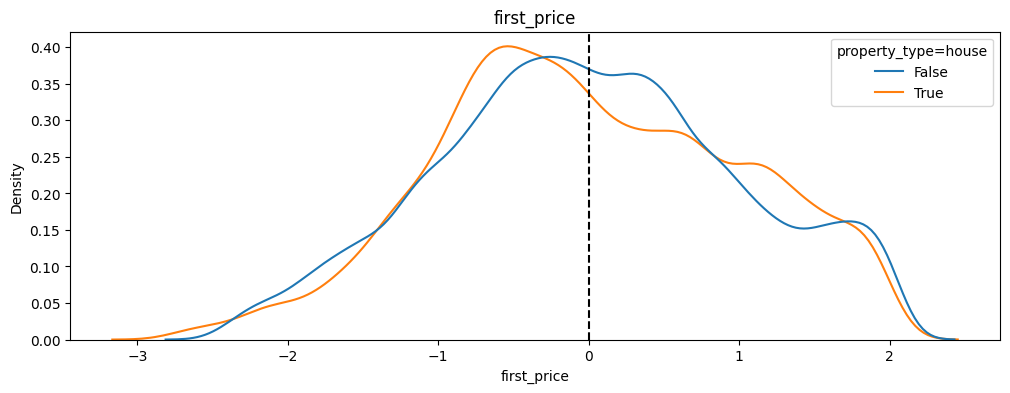

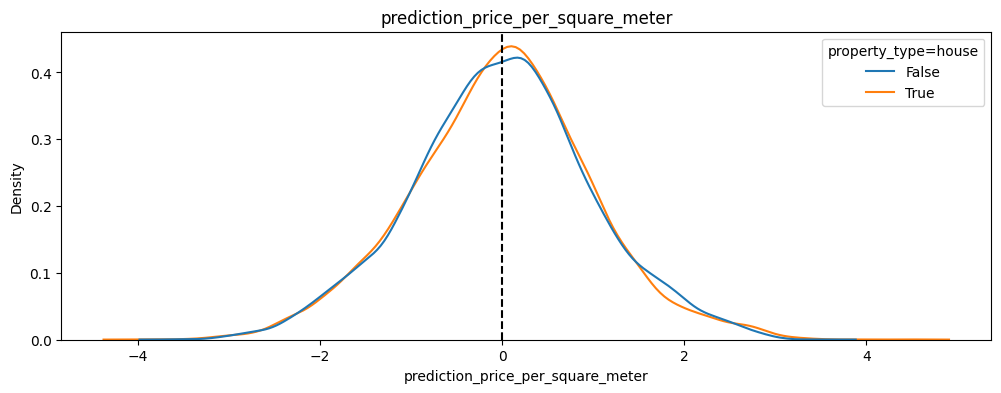

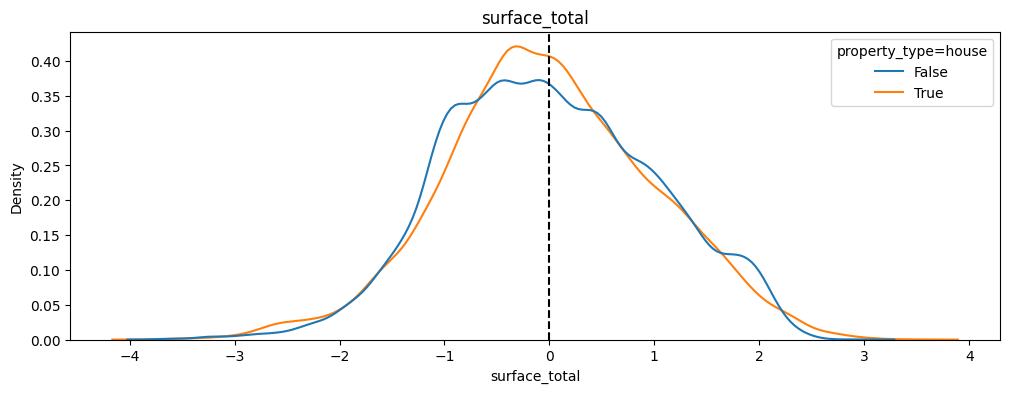

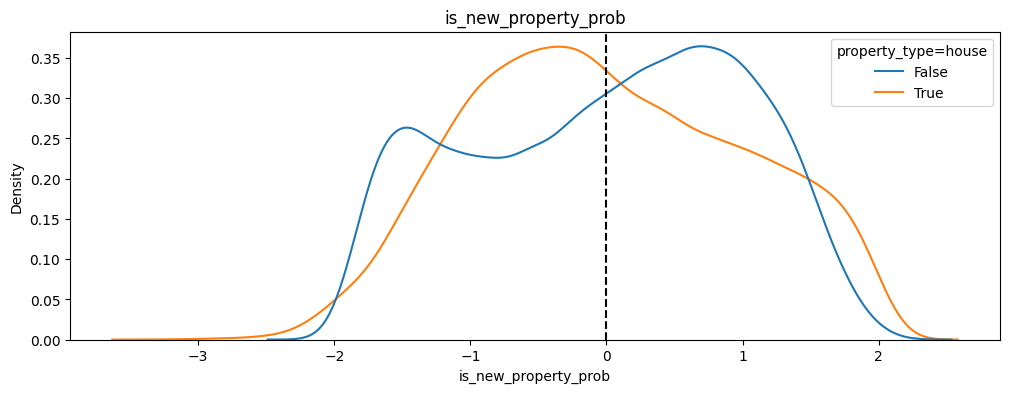

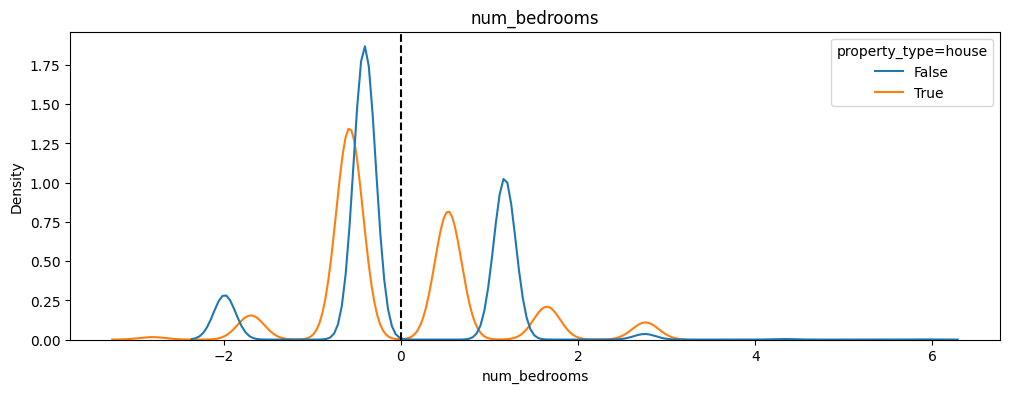

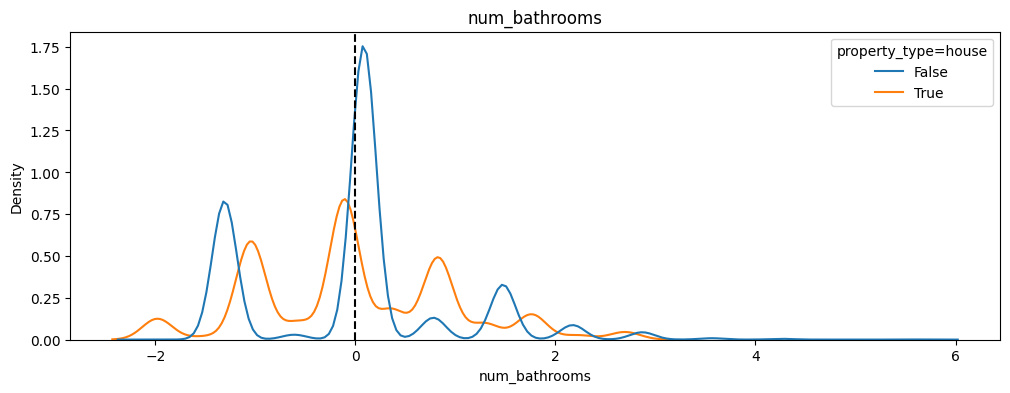

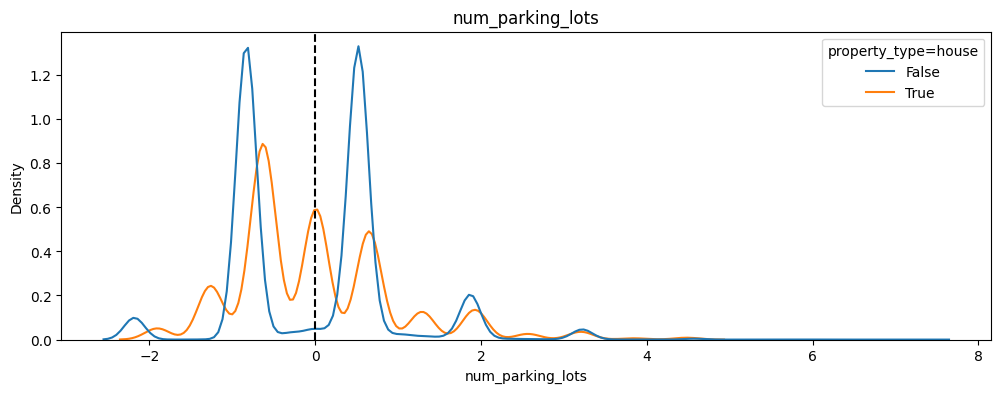

In [14]:
# look distribution of the variables boxcox_vars_property & standard_vars by property type
for col in boxcox_vars_property + standard_vars:
    fig, ax = plt.subplots(1, figsize=(12, 4))
    df_plot = df_postprocess[[col, 'property_type=house']].copy()
    df_plot['property_type=house'] = df_plot['property_type=house'].astype('bool')
    sns.kdeplot(data=df_plot, x=col, hue='property_type=house',common_norm=False)
    # add v line in 0 
    ax.axvline(0, color='black', linestyle='--')
    # add title
    ax.set_title(f'{col}')
    plt.show()

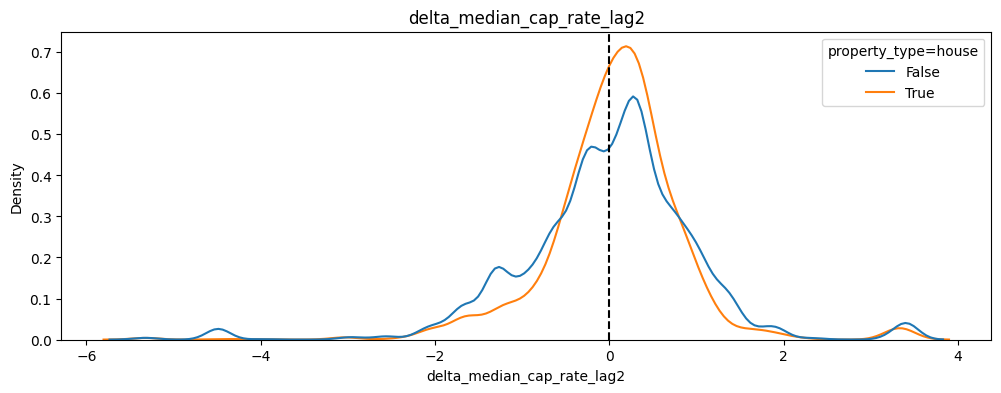

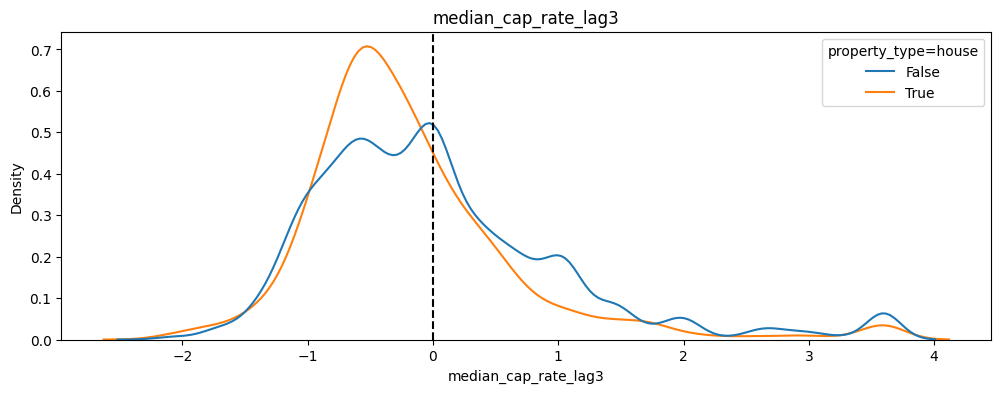

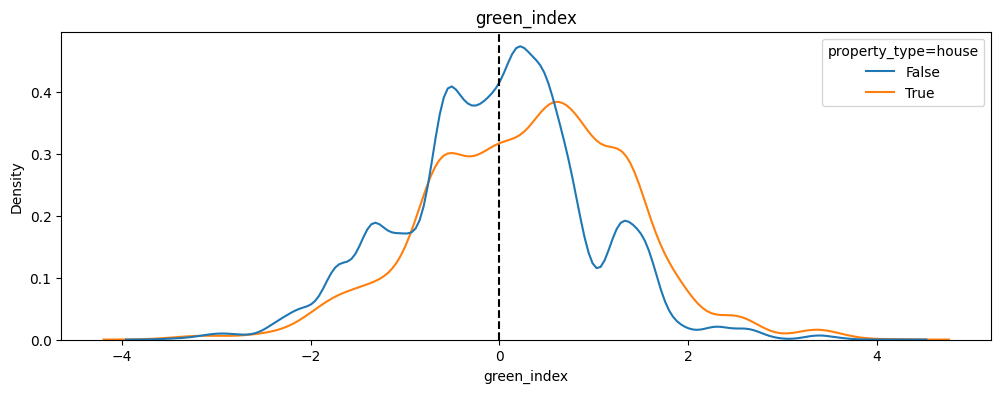

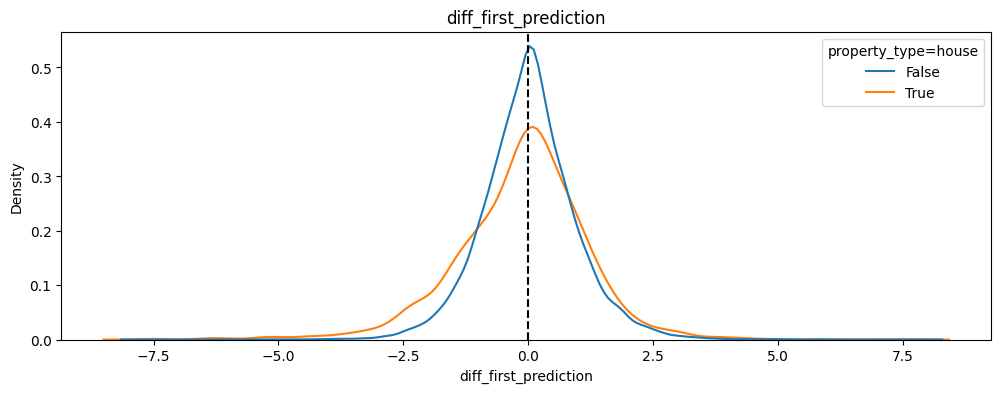

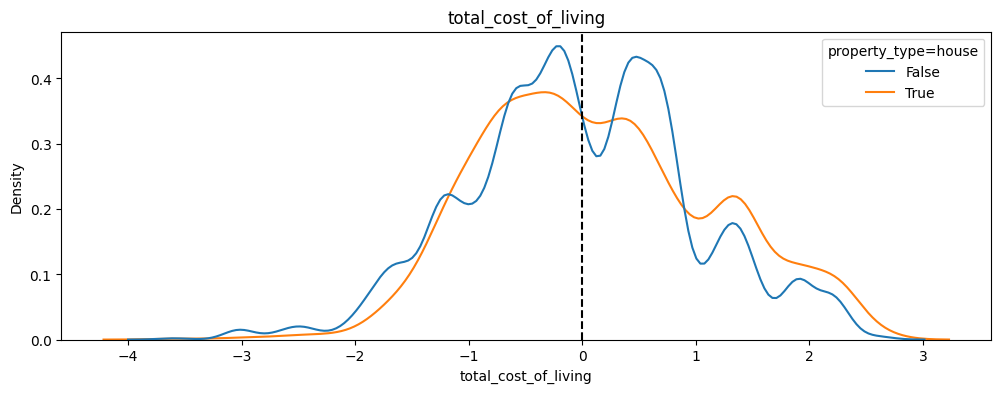

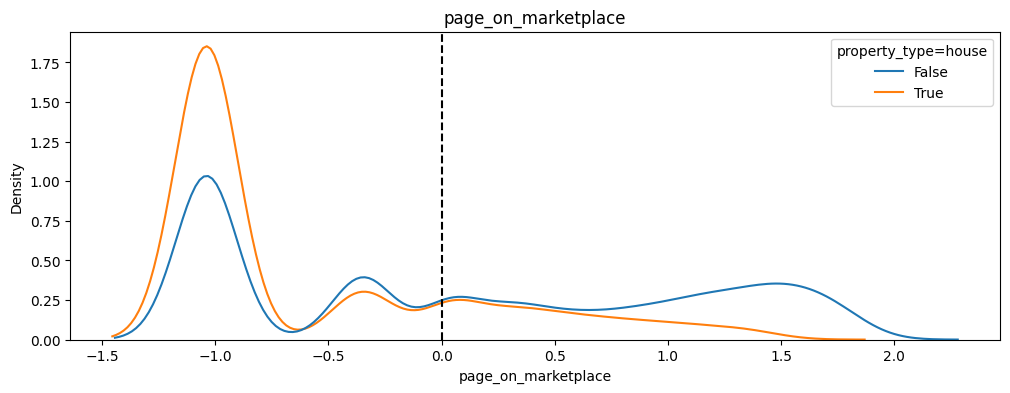

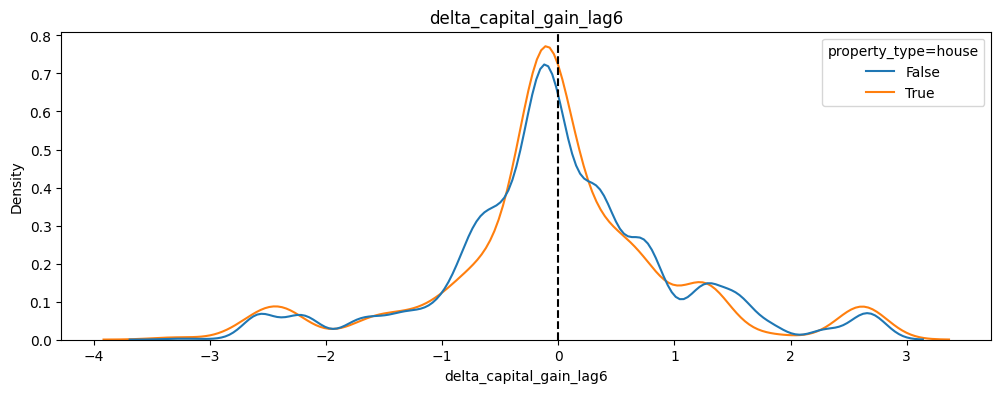

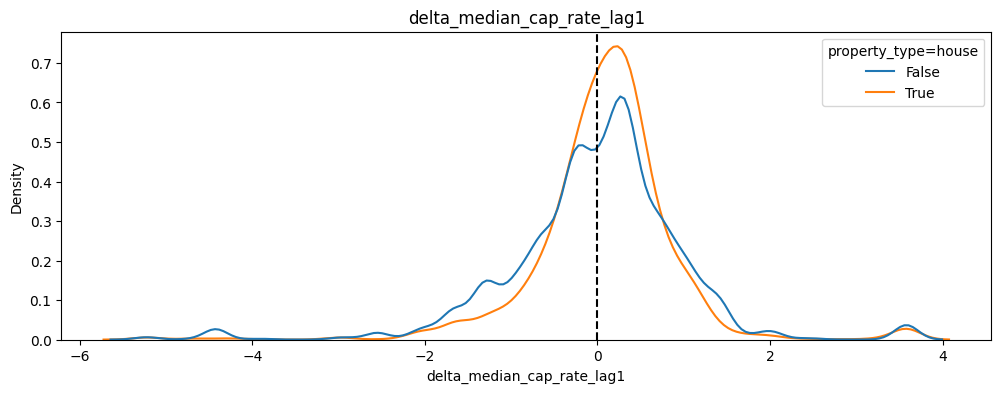

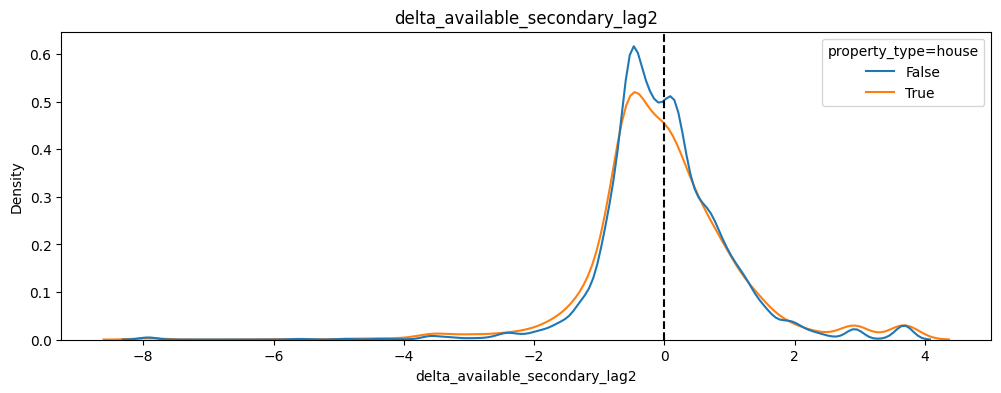

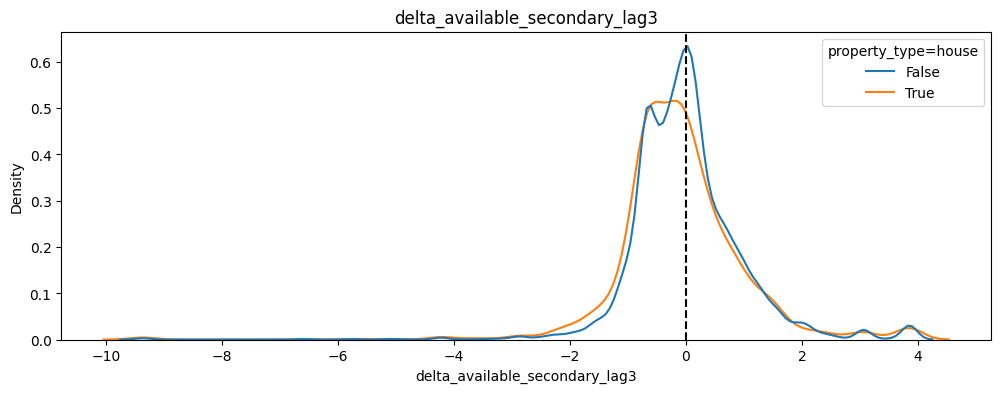

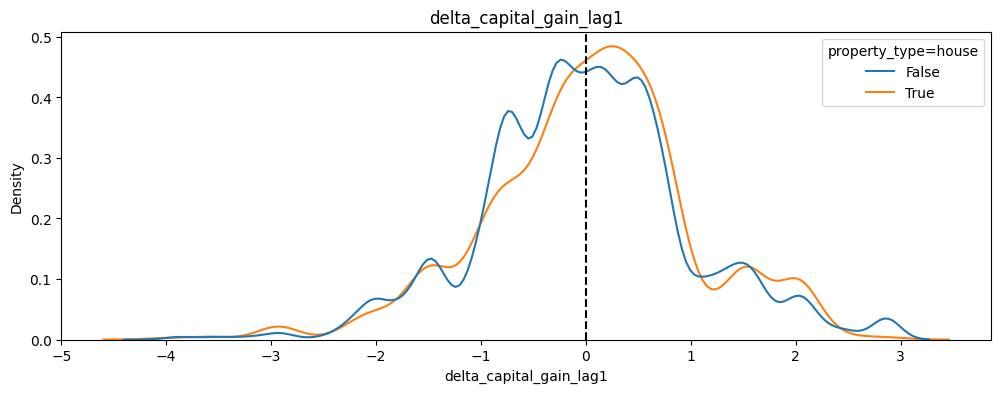

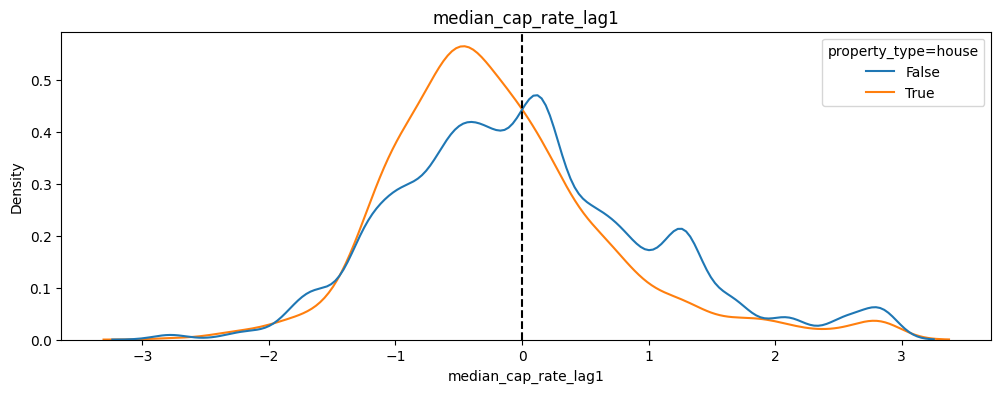

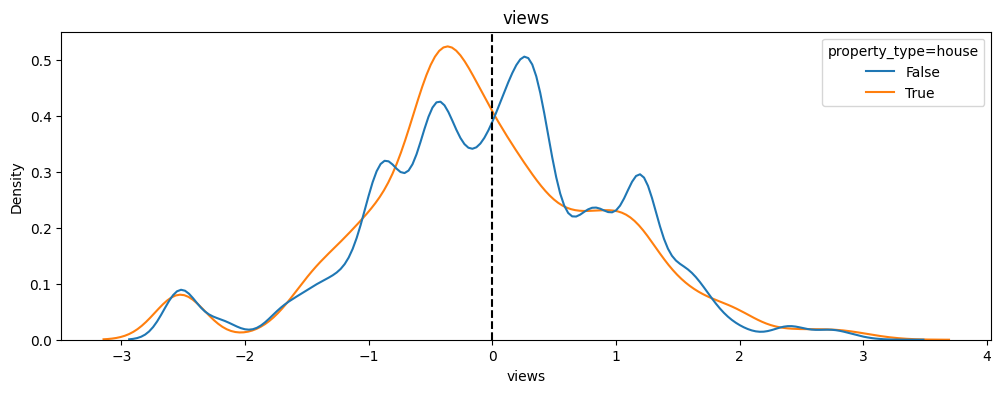

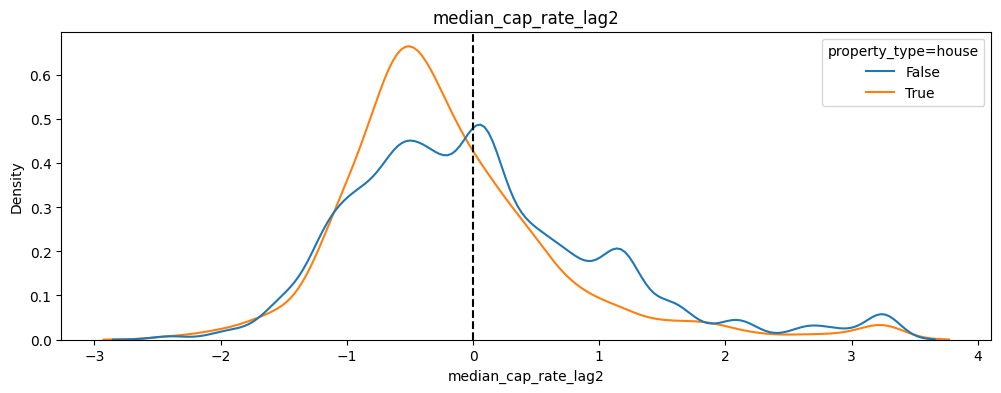

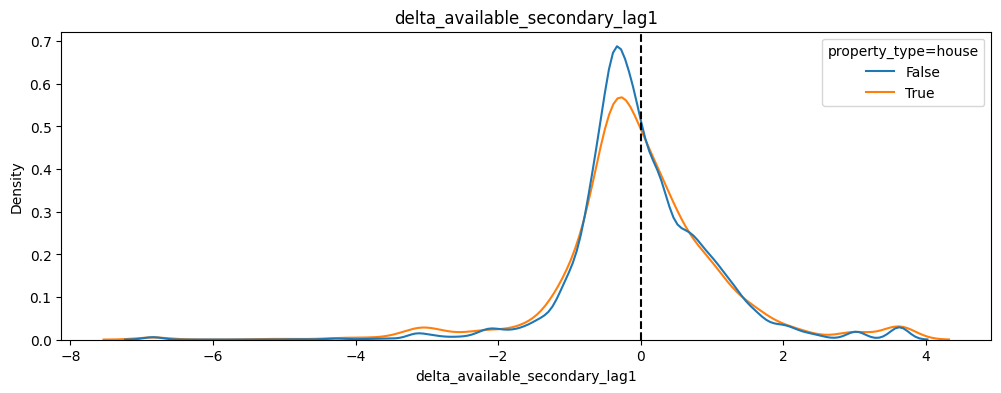

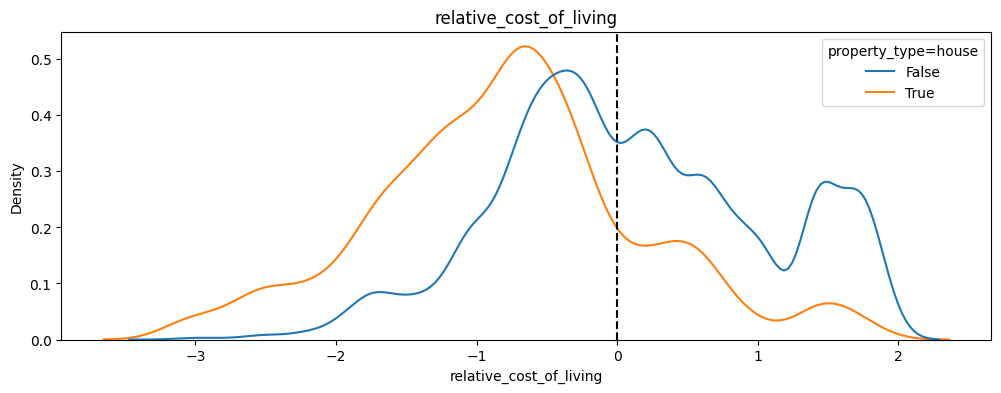

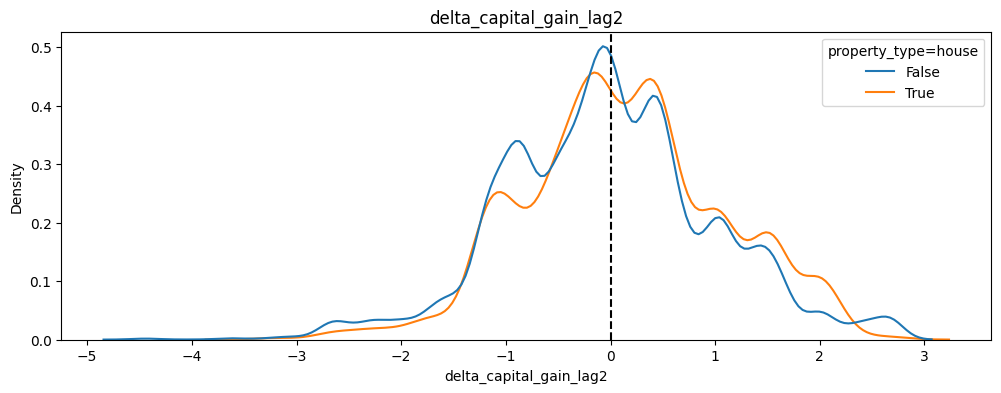

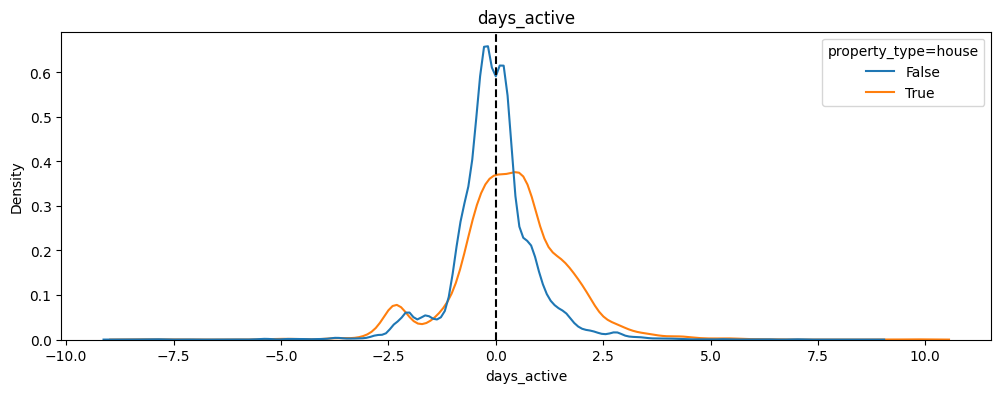

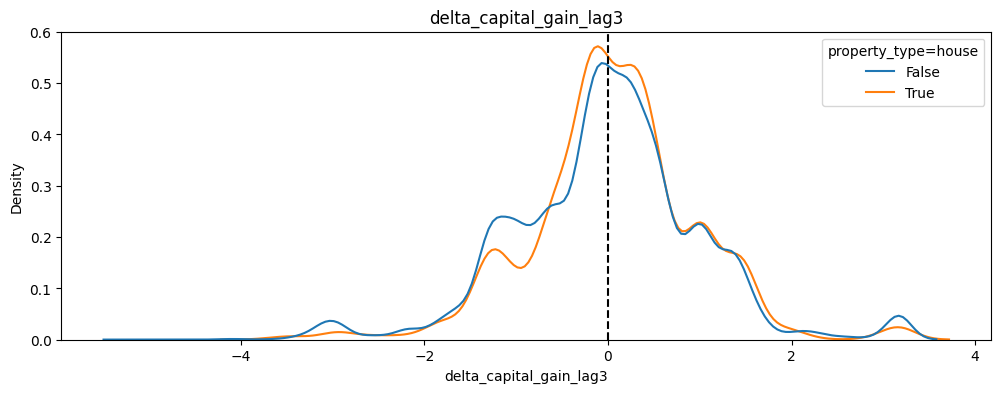

In [46]:
for col in boxcox_vars_all:
    fig, ax = plt.subplots(1, figsize=(12, 4))
    df_plot = df_postprocess[[col, 'property_type=house']].copy()
    df_plot['property_type=house'] = df_plot['property_type=house'].astype('bool')
    sns.kdeplot(data=df_plot, x=col, hue='property_type=house',common_norm=False)
    # add v line in 0 
    ax.axvline(0, color='black', linestyle='--')
    # add title
    ax.set_title(f'{col}')
    plt.show()

In [15]:
df_postprocess.describe()

,property_type=house,first_price,diff_first_prediction,prediction_price_per_square_meter,delta_available_secondary_lag1,delta_available_secondary_lag2,delta_available_secondary_lag3,delta_capital_gain_lag6,delta_capital_gain_lag3,delta_capital_gain_lag2,...,num_bedrooms,num_bathrooms,num_parking_lots,latitude,longitude,sine_tmonth,cosine_tmonth,woe_marketplace,woe_seller,woe_id_sepomex
count,47397.000000,4.739700e+04,4.739700e+04,4.739700e+04,4.739700e+04,4.739700e+04,4.739700e+04,4.739700e+04,4.739700e+04,4.739700e+04,...,4.739700e+04,4.739700e+04,4.739700e+04,47397.000000,47397.000000,4.739700e+04,47397.000000,47397.000000,47397.000000,47397.000000
mean,0.274490,-3.070219e-16,-2.638469e-17,-2.993463e-15,4.077634e-17,2.158747e-17,-1.439165e-17,4.797217e-18,1.679026e-17,5.756660e-17,...,1.888904e-17,1.055388e-16,-1.439165e-17,19.381708,-99.182935,-5.629056e-02,-0.593884,0.017720,0.359616,0.014871
std,0.446262,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,...,1.000011e+00,1.000011e+00,1.000011e+00,0.052333,0.050146,7.031281e-01,0.386985,0.557415,1.930202,0.349335
min,0.000000,-2.714519e+00,-7.129590e+00,-3.922429e+00,-6.815126e+00,-8.586305e+00,-1.050162e+01,-3.343679e+00,-4.900653e+00,-4.180777e+00,...,-2.804606e+00,-2.003877e+00,-2.182096e+00,19.132683,-99.333861,-1.000000e+00,-1.000000,-1.017859,-2.276855,-0.481070
25%,0.000000,-7.030757e-01,-5.250429e-01,-6.430929e-01,-4.730146e-01,-5.706576e-01,-5.655475e-01,-4.185160e-01,-4.923914e-01,-6.374940e-01,...,-4.078379e-01,-1.044001e+00,-8.311379e-01,19.350770,-99.211475,-8.660254e-01,-0.866025,0.223425,-0.025435,-0.094160
50%,0.000000,-4.462756e-02,1.165630e-02,1.050090e-02,-9.839318e-02,-8.659265e-02,-7.445312e-02,-9.024148e-02,-2.686537e-02,-5.685505e-02,...,-4.078379e-01,8.380182e-02,1.098353e-02,19.381056,-99.176572,1.224647e-16,-0.866025,0.223425,-0.025435,-0.094160
75%,1.000000,7.047845e-01,5.321472e-01,6.277988e-01,4.783837e-01,4.468387e-01,3.637134e-01,5.096616e-01,5.062611e-01,5.528096e-01,...,1.172546e+00,8.380182e-02,5.198207e-01,19.416821,-99.152583,5.000000e-01,-0.500000,0.223425,-0.025435,0.200317
max,1.000000,2.059965e+00,1.375907e+01,4.455095e+00,3.549428e+00,3.563836e+00,3.802320e+00,2.684439e+00,3.288541e+00,2.614716e+00,...,5.913696e+00,5.650946e+00,7.274613e+00,19.563492,-98.961825,1.000000e+00,0.500000,0.533409,7.489059,0.967119


## Split data

In [16]:
# split train & test
X_train, X_test, y_train, y_test = train_test_split(
    data_x_numeric, data_y, test_size=0.1, random_state=42, stratify=data_x['listing_type']
)

## Elastic Net Cox Model

### Naive

In [17]:
X_train.shape

(42657, 39)

In [24]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=1, alphas=np.logspace(-5, 3, 10))
cox_elastic_net.fit(X_train, y_train)

CoxnetSurvivalAnalysis(alphas=array([1.00000000e-05, 7.74263683e-05, 5.99484250e-04, 4.64158883e-03,
       3.59381366e-02, 2.78255940e-01, 2.15443469e+00, 1.66810054e+01,
       1.29154967e+02, 1.00000000e+03]),
                       l1_ratio=1)

In [25]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(12, 12))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], "-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

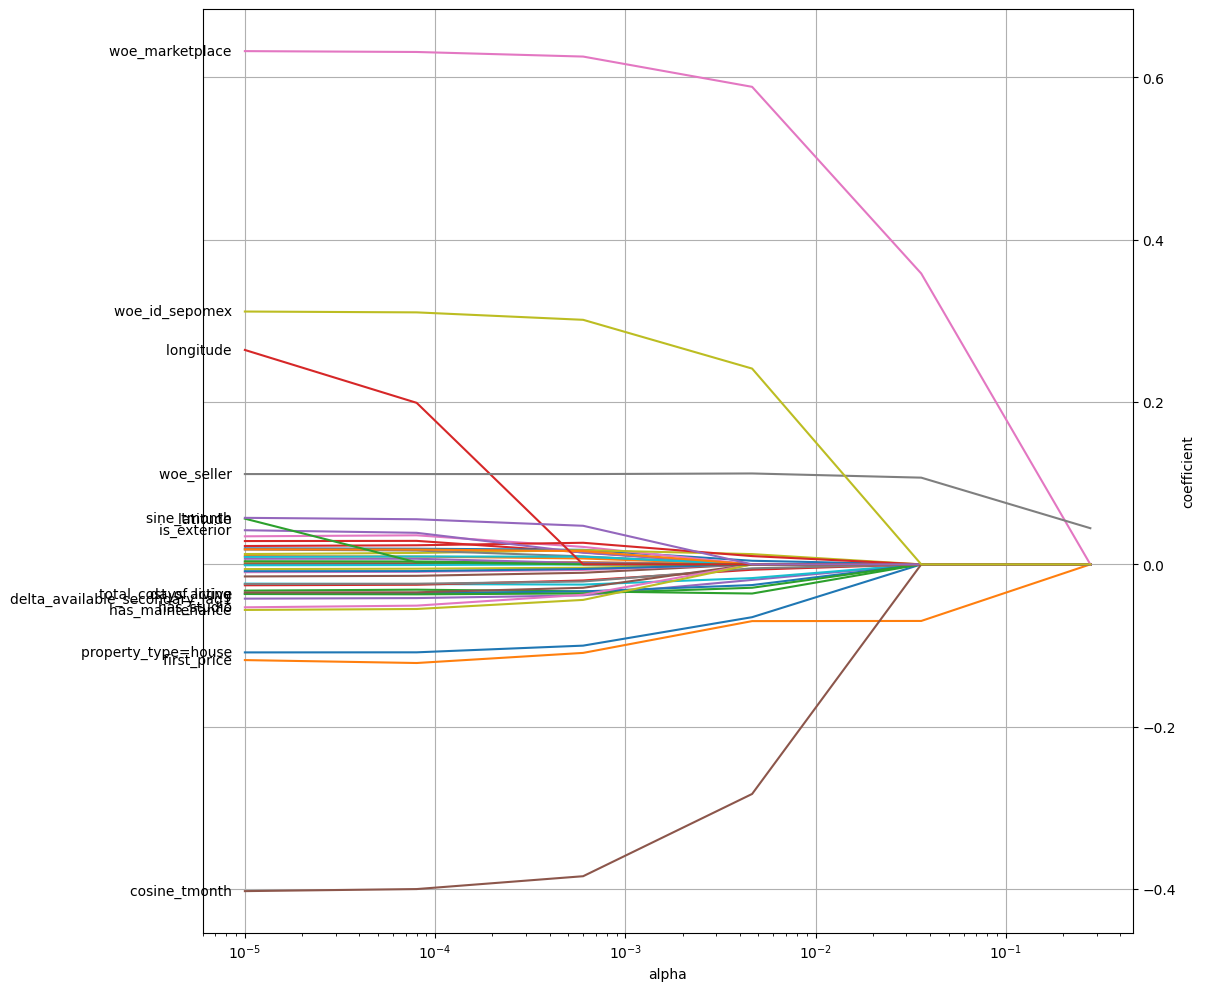

In [26]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_, index=colnames_x_numeric, columns=np.round(cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=15)

### Random Forest

In [27]:
from sklearn.inspection import permutation_importance

rsf = ExtraSurvivalTrees(
    n_estimators=100, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=42
)
rsf.fit(X_train, y_train)

ExtraSurvivalTrees(min_samples_leaf=15, min_samples_split=10, n_jobs=-1,
                   random_state=42)

In [29]:
result = permutation_importance(rsf, X_train[:1000], y_train[:1000], n_repeats=3, random_state=42)

In [30]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=colnames_x_numeric,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
woe_marketplace,0.079329,0.003945
woe_seller,0.048290,0.004730
sine_tmonth,0.033062,0.003270
cosine_tmonth,0.018858,0.002732
page_on_marketplace,0.011535,0.002371
woe_id_sepomex,0.010790,0.001256
property_type=house,0.005900,0.000507
first_price,0.005462,0.000125
total_cost_of_living,0.004396,0.000316
has_gym,0.004252,0.000433


# Conclusions

## linear model

Using the elastic net, I see that the most important features are:
- woe market & seller (great predictor)
- woe sepomex (good predictor)
- tmonth (good predictor)
- first_price (good predictor)
- lon & lat (good predictor)
- property_type (good predictor)
- total_cost (fare predictor)
- cost_of_living
- delta_secondary_lag1 
- is_exterior


## non-linear feature importance

Using random forest to select features, we can see that the most important features are:
- woes market & seller
- tmonth
- page on marketplace
- woe sepomex
- property type
- first price
- total cost of living
- gym
- pets
- surface
- bathrooms
- price per m2
- pets allowed
- total cost
- num parking
- has gym
- surface

Although, i will try to enforce `diff_first_price` to the model, because it makes economic sense.